In [2]:
""" After analyze_hVOS_parallel.py is run on the HTC clusters,
    the result are files output_dir_#.tar.gz files in the directory,
    'analyze_output' where # is the number of the job and also the 
    index of the Cell. 
    This script will extract the files and rename them"""
import os
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import imageio

from src.hVOS.camera import Camera

In [3]:
data_dir = 'analyze_output/'
run_id = 2
sparsity = 0.5  # max sparsity is 0.6. A sparsity of 0.5 uses 0.5/0.6 = 0.8333 of the data
should_re_extract = True  # set to True if you want to re-extract the data into existing folders

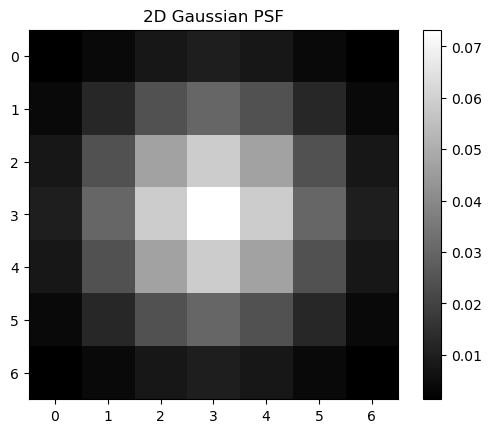

In [4]:
# create a 2-d gaussian PSF with a sigma of 1.5 pixels
psf_2d = np.zeros((7, 7))
for i in range(7):
    for j in range(7):
        psf_2d[i, j] = np.exp(-((i - 3) ** 2 + (j - 3) ** 2) / (2 * 1.5 ** 2))

# normalize the PSF
psf_2d /= np.sum(psf_2d)

plt.imshow(psf_2d, cmap='gray')
plt.colorbar()
plt.title('2D Gaussian PSF')
plt.show()

In [5]:
output_dir_dict = {}
for file in os.listdir(data_dir):
    if file.endswith('.tar.gz'):
        # Extract the tar.gz file
        output_dir = data_dir + file[:-7] + '/'
        print(data_dir + file)
        if not os.path.exists(output_dir) or should_re_extract:
            if not os.path.exists(output_dir):
                print("\tCreating directory:", output_dir)
                os.makedirs(output_dir)
            result = subprocess.run(['tar', '-xzvf', data_dir + file, "-C", output_dir], 
                                    capture_output=True, text=True, check=True)
        i_output = int(file.replace(".tar.gz", "").split("_")[-1])
        output_dir_dict[i_output] = output_dir
output_dir_dict


analyze_output/output_dir_0.tar.gz
analyze_output/output_dir_1.tar.gz
analyze_output/output_dir_10.tar.gz
analyze_output/output_dir_100.tar.gz
analyze_output/output_dir_101.tar.gz
analyze_output/output_dir_102.tar.gz
analyze_output/output_dir_103.tar.gz
analyze_output/output_dir_104.tar.gz
analyze_output/output_dir_105.tar.gz
analyze_output/output_dir_106.tar.gz
analyze_output/output_dir_107.tar.gz
analyze_output/output_dir_108.tar.gz
analyze_output/output_dir_109.tar.gz
analyze_output/output_dir_11.tar.gz
analyze_output/output_dir_110.tar.gz
analyze_output/output_dir_111.tar.gz
analyze_output/output_dir_112.tar.gz
analyze_output/output_dir_113.tar.gz
analyze_output/output_dir_114.tar.gz
analyze_output/output_dir_115.tar.gz
analyze_output/output_dir_116.tar.gz
analyze_output/output_dir_117.tar.gz
analyze_output/output_dir_118.tar.gz
analyze_output/output_dir_119.tar.gz
analyze_output/output_dir_12.tar.gz
analyze_output/output_dir_120.tar.gz
analyze_output/output_dir_121.tar.gz
analyze_

{0: 'analyze_output/output_dir_0/',
 1: 'analyze_output/output_dir_1/',
 10: 'analyze_output/output_dir_10/',
 100: 'analyze_output/output_dir_100/',
 101: 'analyze_output/output_dir_101/',
 102: 'analyze_output/output_dir_102/',
 103: 'analyze_output/output_dir_103/',
 104: 'analyze_output/output_dir_104/',
 105: 'analyze_output/output_dir_105/',
 106: 'analyze_output/output_dir_106/',
 107: 'analyze_output/output_dir_107/',
 108: 'analyze_output/output_dir_108/',
 109: 'analyze_output/output_dir_109/',
 11: 'analyze_output/output_dir_11/',
 110: 'analyze_output/output_dir_110/',
 111: 'analyze_output/output_dir_111/',
 112: 'analyze_output/output_dir_112/',
 113: 'analyze_output/output_dir_113/',
 114: 'analyze_output/output_dir_114/',
 115: 'analyze_output/output_dir_115/',
 116: 'analyze_output/output_dir_116/',
 117: 'analyze_output/output_dir_117/',
 118: 'analyze_output/output_dir_118/',
 119: 'analyze_output/output_dir_119/',
 12: 'analyze_output/output_dir_12/',
 120: 'analyze

In [6]:
comparts = ['axon', 'dend', 'soma', 'apic']
all_cells_rec = {
    p: { 
        c: {
            'syn': None,
            'spk': None,
        } for c in comparts
    } for p in ['no_psf', 'psf']
}

for i_output in output_dir_dict.keys():
    output_dir = output_dir_dict[i_output] + "run" + str(run_id) + "/model_rec_final/"
    if not os.path.exists(output_dir):
        continue
    for file in os.listdir(output_dir):
        if file.endswith('.npy'):
            # open numpy memmap file 
            file_path = output_dir + file
            print(file_path)
            arr = np.memmap(file_path, dtype='float32', mode='r').reshape(-1, 300, 300)

            # use the file name to determine the compartment and type of data
            # e.g. no_psf_cell_8406-syn_rec_dend.npy
            # e.g. psf_cell_8406-spk_rec_soma.npy
            # e.g. psf_cell_8406-syn_rec_apic.npy

            compart_type = file.split("_")[-1].replace(".npy", "")
            psf_type = file.split("_")[0]
            psf_type = 'no_psf' if psf_type == 'no' else 'psf'
            activity_type = file.split("_")[-3]
            print(activity_type)
            activity_type = activity_type.split("-")[1]
            cell_id = file.split("_")[1].split("-")[0]

            print(compart_type, psf_type, activity_type, cell_id)

            if all_cells_rec[psf_type][compart_type][activity_type] is None:
                all_cells_rec[psf_type][compart_type][activity_type] = \
                    np.zeros(arr.shape, dtype='float32')
            
            all_cells_rec[psf_type][compart_type][activity_type] += arr


analyze_output/output_dir_0/run2/model_rec_final/psf_cell_12145-syn_rec_apic.npy
12145-syn
apic psf syn cell
analyze_output/output_dir_0/run2/model_rec_final/psf_cell_12145-syn_rec_dend.npy
12145-syn
dend psf syn cell
analyze_output/output_dir_1/run2/model_rec_final/psf_cell_8483-syn_rec_apic.npy
8483-syn
apic psf syn cell
analyze_output/output_dir_1/run2/model_rec_final/psf_cell_8483-syn_rec_dend.npy
8483-syn
dend psf syn cell
analyze_output/output_dir_10/run2/model_rec_final/psf_cell_8489-syn_rec_apic.npy
8489-syn
apic psf syn cell
analyze_output/output_dir_10/run2/model_rec_final/psf_cell_8489-syn_rec_dend.npy
8489-syn
dend psf syn cell
analyze_output/output_dir_10/run2/model_rec_final/psf_cell_8489-syn_rec_soma.npy
8489-syn
soma psf syn cell
analyze_output/output_dir_100/run2/model_rec_final/psf_cell_8317-syn_rec_apic.npy
8317-syn
apic psf syn cell
analyze_output/output_dir_100/run2/model_rec_final/psf_cell_8317-syn_rec_dend.npy
8317-syn
dend psf syn cell
analyze_output/output_dir_

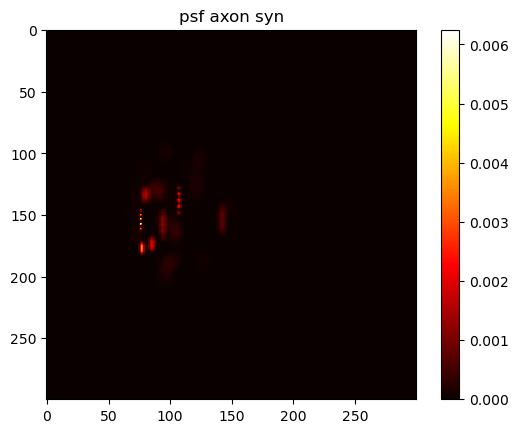

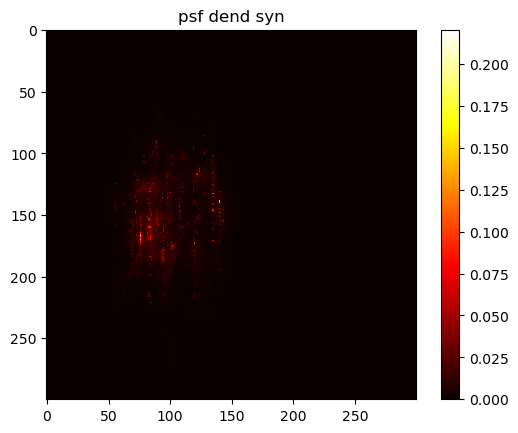

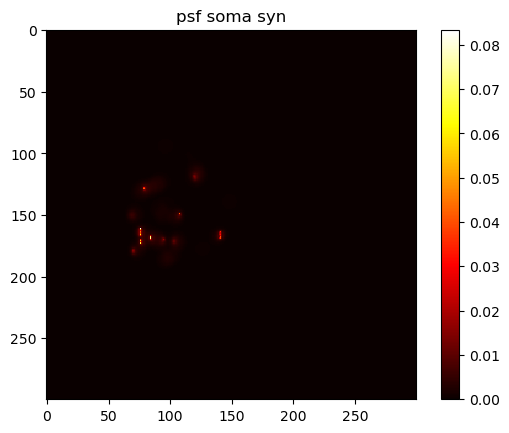

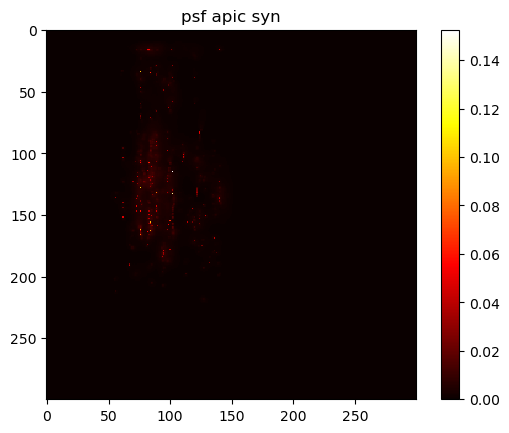

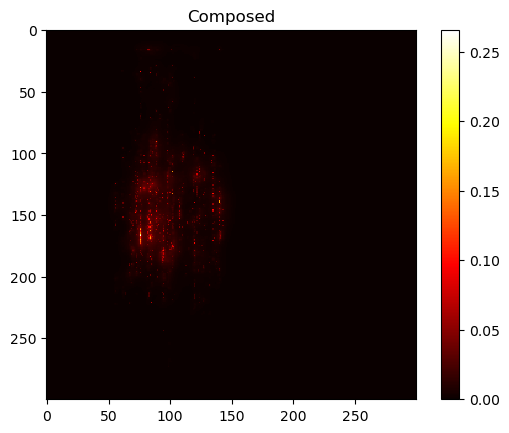

In [8]:
# finally, show each of the results in all_cells_rec
for psf_type in all_cells_rec.keys():
    composed_arr = None
    for compart_type in all_cells_rec[psf_type].keys():
        for activity_type in all_cells_rec[psf_type][compart_type].keys():
            arr = all_cells_rec[psf_type][compart_type][activity_type]
            if arr is None:
                continue
            if composed_arr is None:
                composed_arr = np.zeros(arr.shape, dtype='float32')
            composed_arr += arr

            if psf_type == 'psf':
                plt.imshow(-arr[0, :, :], cmap='hot', interpolation='nearest')
                plt.colorbar()
                plt.title(f"{psf_type} {compart_type} {activity_type}")
                plt.show()
            elif psf_type == 'no_psf':
                # show it side-by-side with the image blurred with the PSF
                # blur the image with the PSF
                blurred_arr = np.zeros(arr.shape, dtype='float32')
                for i in range(arr.shape[0]):
                    blurred_arr[i, :, :] = signal.convolve2d(arr[i, :, :], psf_2d, mode='same')
                plt.subplot(1, 2, 1)
                plt.imshow(-arr[0, :, :], cmap='hot', interpolation='nearest')
                plt.title(f"{psf_type} {compart_type} {activity_type}")
                plt.subplot(1, 2, 2)
                plt.imshow(-blurred_arr[0, :, :], cmap='hot', interpolation='nearest')
                plt.title(f"{psf_type} {compart_type} {activity_type} blurred")
                plt.show()
                # save the blurred image
                plt.savefig(f"{psf_type}_{compart_type}_{activity_type}_blurred.png")

    if composed_arr is None:
        continue
    # show composed_arr
    plt.imshow(-composed_arr[0, :, :], cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title(f"Composed")
    plt.show()

    if psf_type == 'no_psf':
        blurred_composed_arr = np.zeros(composed_arr.shape, dtype='float32')
        for i in range(composed_arr.shape[0]):
            blurred_composed_arr[i, :, :] = signal.convolve2d(composed_arr[i, :, :], psf_2d, mode='same')
        plt.imshow(-blurred_composed_arr[0, :, :], cmap='hot', interpolation='nearest')
        plt.title(f"Composed w/ PSF")
        plt.colorbar()
        plt.show()
    

In [ ]:
# load time 
# load time
data_dir = 'C:/Users/jjudge3/Desktop/neuron docker/' # /path/to/compressed/data
target_dir = data_dir + 'archive/run2/'
mm_time_fp = target_dir + 'v7_batch1_0_0_time.dat'
time = np.memmap(mm_time_fp, dtype='float32', mode='r')
print(len(time))


501


CREATED MOVIE: no_psf_axon_syn.gif
CREATED MOVIE: no_psf_axon_syn_blurred.gif
CREATED MOVIE: no_psf_dend_syn.gif
CREATED MOVIE: no_psf_dend_syn_blurred.gif
CREATED MOVIE: no_psf_soma_syn.gif
CREATED MOVIE: no_psf_soma_syn_blurred.gif
CREATED MOVIE: no_psf_apic_syn.gif
CREATED MOVIE: no_psf_apic_syn_blurred.gif
CREATED MOVIE: psf_axon_syn.gif
CREATED MOVIE: psf_dend_syn.gif
CREATED MOVIE: psf_soma_syn.gif
CREATED MOVIE: psf_apic_syn.gif


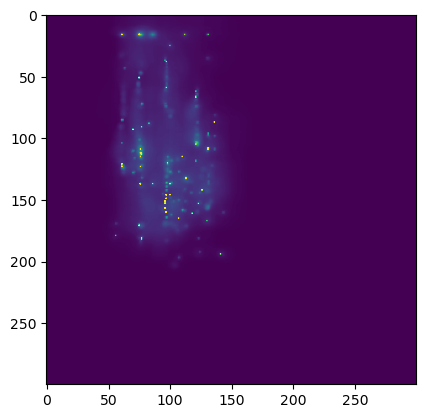

In [ ]:
# make each array into an animated gif using Camera.animate_frames_to_video
cam = Camera([], [], time, init_dummy=True)
final_arr =  {}
for psf_type in all_cells_rec.keys():
    for compart_type in all_cells_rec[psf_type].keys():
        for activity_type in all_cells_rec[psf_type][compart_type].keys():
            arr = all_cells_rec[psf_type][compart_type][activity_type]
            gif_filename = f"{psf_type}_{compart_type}_{activity_type}.gif"
            if arr is None:
                continue
            cam.animate_frames_to_video(arr, gif_filename, frames=(0, 501))

            if psf_type == 'no_psf':
                # blur the image with the PSF
                blurred_arr = np.zeros(arr.shape, dtype='float32')
                for i in range(arr.shape[0]):
                    blurred_arr[i, :, :] = signal.convolve2d(arr[i, :, :], psf_2d, mode='same')
                cam.animate_frames_to_video(blurred_arr, gif_filename.replace('.gif', '_blurred.gif'), frames=(0, 501))

            # store the arr
            if psf_type not in final_arr:
                final_arr[psf_type] = {}
            if compart_type not in final_arr[psf_type]:
                final_arr[psf_type][compart_type] = {}
            if activity_type not in final_arr[psf_type][compart_type]:
                final_arr[psf_type][compart_type][activity_type] = {}
            final_arr[psf_type][compart_type][activity_type] = arr

            if psf_type == 'no_psf':
                if 'blurred_arr' not in final_arr:
                    final_arr['blurred_arr'] = {}
                if compart_type not in final_arr['blurred_arr']:
                    final_arr['blurred_arr'][compart_type] = {}
                if activity_type not in final_arr['blurred_arr'][compart_type]:
                    final_arr['blurred_arr'][compart_type][activity_type] = {}

                final_arr['blurred_arr'][compart_type][activity_type] = blurred_arr

            


In [ ]:
final_composed_arr = {}
for psf_type in final_arr.keys():
    if psf_type not in final_composed_arr:
        final_composed_arr[psf_type] = None
    for compart_type in final_arr[psf_type].keys():
        for activity_type in final_arr[psf_type][compart_type].keys():
            arr = final_arr[psf_type][compart_type][activity_type]
            if final_composed_arr[psf_type] is None:
                final_composed_arr[psf_type] = np.zeros(arr.shape, dtype='float32')
            final_composed_arr[psf_type] += arr

In [ ]:
# build 4 hisograms: # pixels for % compartment contribution for each compartment
# for each of the 4 compartments
# 1. get the max amp for each compartment
# 2. get the sum of the max amps for each compartment
# 3. get the % contribution for each compartment
# 4. plot the histogram for each compartment
# 5. save the histogram as a png file
t_stride = 10
for psf_type in final_arr.keys():
    #filter
    if psf_type != 'blurred_arr':
        continue
    images = []
    for t in range(0, len(time), t_stride):
        print("processing t = ", t)
        plt.clf()
        plt.figure(figsize=(10, 6))
        for compart_type in final_arr[psf_type].keys():
            for activity_type in final_arr[psf_type][compart_type]:
                arr = final_arr[psf_type][compart_type][activity_type]
                if arr is None:
                    continue
                as_fraction_arr = arr / final_composed_arr[psf_type]
            
                # discard elements that are not in the range (0, 1]
                as_fraction_arr_t = as_fraction_arr[t, :, :]
                as_fraction_arr_t = as_fraction_arr_t[as_fraction_arr_t > 0]
                as_fraction_arr_t = as_fraction_arr_t[as_fraction_arr_t <= 1]
                # get the histogram of the % contribution for each compartment

            plt.hist(as_fraction_arr_t.flatten(), bins=100, 
                     label=compart_type, histtype='step',
                     linewidth=2,)
        plt.title(f" Contributions of each compartment to pixel (t = {time[t]} ms)")
        plt.xlabel("percent contribution")
        plt.legend()
        plt.ylabel("number of pixels")
        # make log y-scale
        plt.yscale('log')
        filename = f"{psf_type}_{compart_type}_percent_contribution_t_" + str(t) + ".png"
        plt.savefig(filename)
        plt.close()

        images.append(imageio.imread(filename))
    imageio.mimsave(f"{psf_type}_{compart_type}_percent_contribution.gif", images)
    
        

processing t =  0
processing t =  10
processing t =  20
processing t =  30
processing t =  40
processing t =  50
processing t =  60
processing t =  70
processing t =  80
processing t =  90
processing t =  100
processing t =  110
processing t =  120
processing t =  130
processing t =  140
processing t =  150
processing t =  160
processing t =  170
processing t =  180
processing t =  190
processing t =  200
processing t =  210
processing t =  220
processing t =  230
processing t =  240
processing t =  250
processing t =  260
processing t =  270
processing t =  280
processing t =  290
processing t =  300
processing t =  310
processing t =  320
processing t =  330
processing t =  340
processing t =  350
processing t =  360
processing t =  370
processing t =  380
processing t =  390
processing t =  400
processing t =  410
processing t =  420
processing t =  430
processing t =  440
processing t =  450
processing t =  460
processing t =  470
processing t =  480
processing t =  490
processing 

<Figure size 640x480 with 0 Axes>